In [3]:
import os
import numpy as np
import h5py
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pytorch_lightning import LightningModule
from sklearn.model_selection import train_test_split

In [4]:
# Path setup
model_path = "fine_tuned_model_v8-epoch=7336-train_loss=0.00666.ckpt"  
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'
save_dir = r'C:\Users\kiena\Python Project\Year4Project\dev\GarstecModel_V8' 
os.makedirs(save_dir, exist_ok=True)

In [5]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
        return [optimizer], [scheduler]


In [9]:
def load_data():
    # 7 Inputs
    ages = []
    massini = []
    fehini = []
    alphamlt = []
    yini = []
    eta = []
    alphafe = []

    # 5 Outputs
    teff = []
    luminosity = []
    dnufit = []
    FeH = []
    numax = []

    # Open the hdf5 file
    with h5py.File(garstec_data, 'r') as hdf:
        grid = hdf['grid']
        tracks = grid['tracks']

        # Get track names and shuffle
        track_names = list(tracks.keys())
        random.seed(1)  # Use same seed as in training
        random.shuffle(track_names)

        # Choose a subset of tracks
        selected_tracks = track_names[:]

        for track_name in selected_tracks:
            track = tracks[track_name]
            # Inputs
            ages.append(track['age'][:])
            massini.append(track['massini'][:])
            fehini.append(track['FeHini'][:])
            alphamlt.append(track['alphaMLT'][:])
            yini.append(track['yini'][:])
            eta.append(track['eta'][:])
            alphafe.append(track['alphaFe'][:])

            # Outputs
            teff.append(track['Teff'][:])
            luminosity.append(track['LPhot'][:])
            dnufit.append(track['dnufit'][:])
            FeH.append(track['FeH'][:])
            numax.append(track['numax'][:])

        # Track which points belong to which tracks
        track_indices = []
        for i, track_name in enumerate(selected_tracks):
            track = tracks[track_name]
            # Add the track index for each point in this track
            track_indices.extend([i] * len(track['Teff'][:]))
    
    track_indices = np.array(track_indices)

    # Convert to numpy arrays and apply transformations
    epsilon = 1e-10
    
    # Transform inputs
    log10_vars_inputs = [ages, massini, alphamlt, eta, yini]
    log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]
    inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), 
                                                  np.concatenate(alphafe).reshape(-1, 1)])
    
    # Transform outputs
    log10_vars_outputs = [teff, luminosity, dnufit, numax]
    log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]
    outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1)])
    
    # Create a list of output parameter names for plotting
    output_names = ['log T_eff', 'log L', 'log dnu', 'log numax', 'FeH']
    
    return inputs, outputs, output_names, track_indices




In [10]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Load data
inputs, outputs, output_names, track_indices = load_data()
    
# Split data with same random state as in training
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)
    
# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
    
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)
    
# Load the trained model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
    
# Load model with map_location to handle device differences
model = GarstecNet.load_from_checkpoint(
    model_path, 
    input_dim=input_dim, 
    output_dim=output_dim,
    map_location=device
)
model.eval()  # Set to evaluation mode
model.to(device)  # Ensure model is on the correct device
    
# Make predictions on test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # Move predictions back to CPU before converting to numpy
    
# Inverse transform predictions and actual values to get original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)
    
# Calculate residuals
log_residuals = y_pred_original - y_test_original


Using device: cuda


C:\Users\kiena\AppData\Local\Temp\ipykernel_10264\2557373262.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(log_residuals, patch_artist=True, labels=x_labels, showfliers=False)


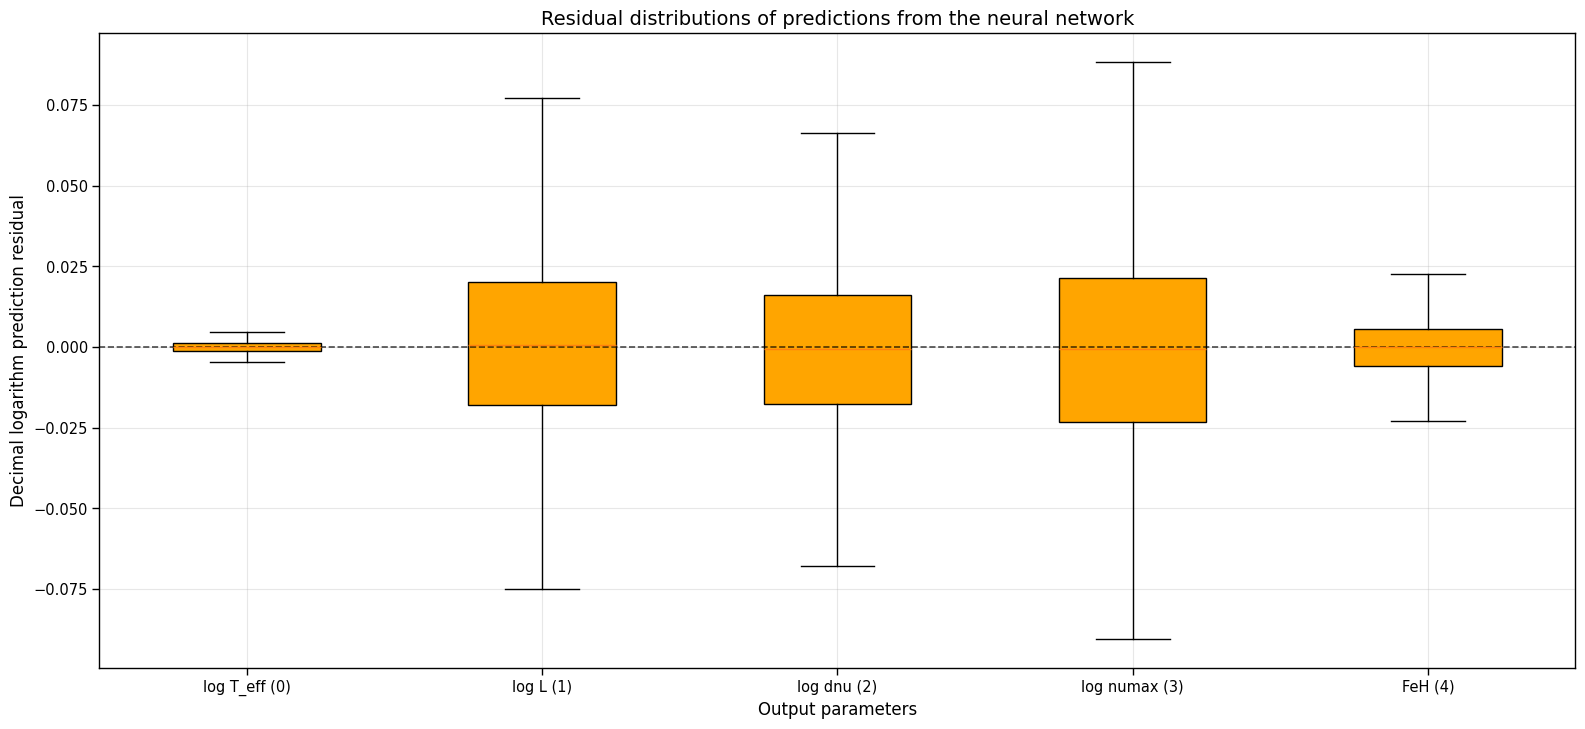

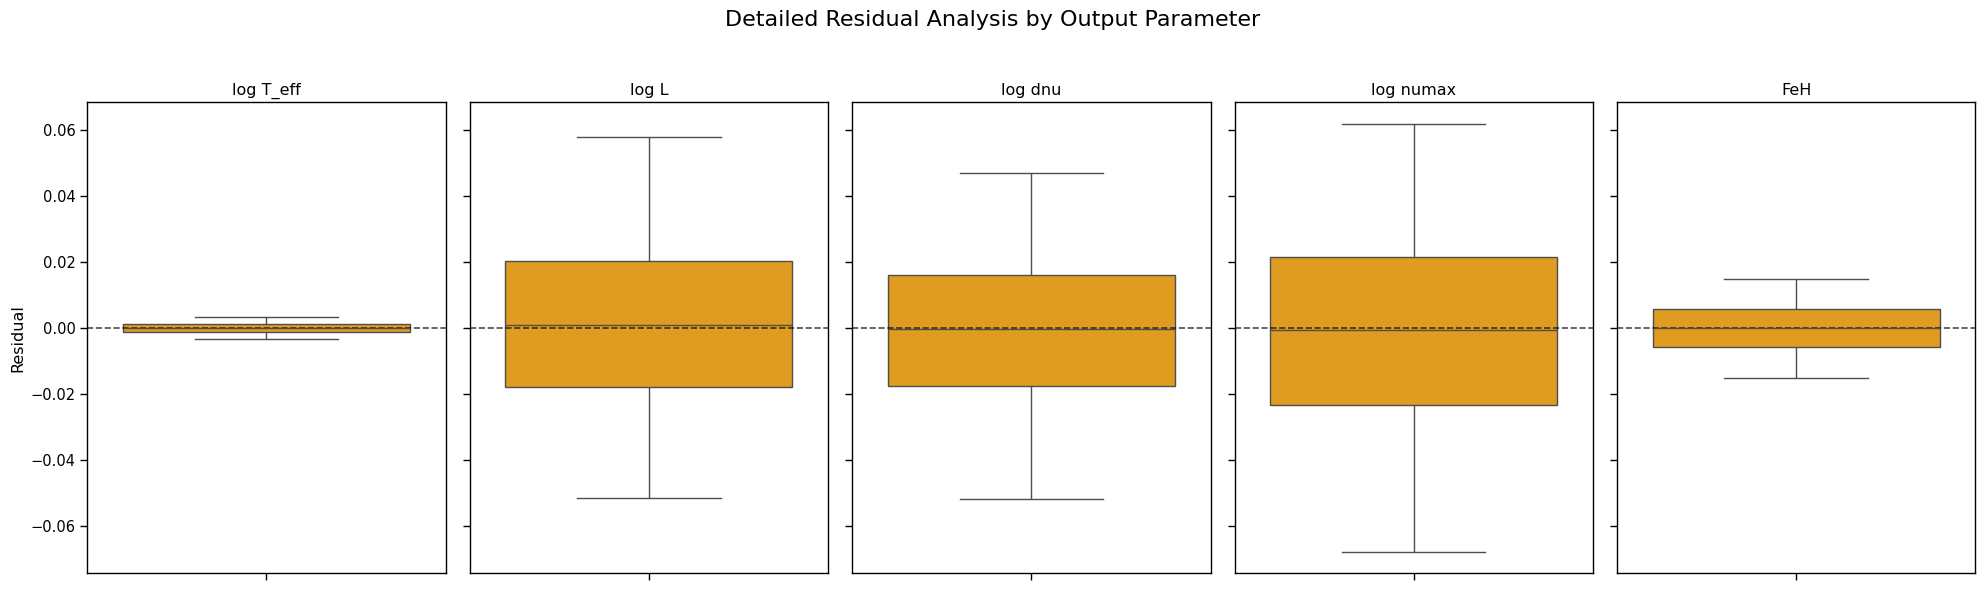

In [32]:
def log_residual_plots():
    
    plt.figure(figsize=(16, 8))
    
    # Prepare x-axis labels with indices
    x_labels = [f'{name} ({i})' for i, name in enumerate(output_names)]
    
    # Create boxplot
    boxplot = plt.boxplot(log_residuals, patch_artist=True, labels=x_labels, showfliers=False)
    
    # Customize boxplot colors
    for box in boxplot['boxes']:
        box.set(facecolor='orange')  # Orange color similar to the reference image
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    
    # Customize plot
    plt.title('Residual distributions of predictions from the neural network', fontsize=14)
    plt.xlabel('Output parameters', fontsize=12)
    plt.ylabel('Decimal logarithm prediction residual', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust for the figtext
    plt.show()
    
    # Create separate boxplots for each output parameter with clear outlier visualization
    fig, axes = plt.subplots(nrows=1, ncols=len(output_names), figsize=(20, 6), sharey=True)
    
    for i, (ax, name) in enumerate(zip(axes, output_names)):
        sns.boxplot(y=log_residuals[:, i], ax=ax, color='orange', showfliers=False, 
                    whis=[5, 95])  # Set whiskers to 5th and 95th percentiles
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        ax.set_title(name)
        if i == 0:
            ax.set_ylabel('Residual')
        else:
            ax.set_ylabel('')
    
    fig.suptitle('Detailed Residual Analysis by Output Parameter', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()


log_residual_plots()

In [25]:
def log_residual_stats():
    # Calculate and print statistics for each output parameter
    print("\nResidual Statistics:")
    print("====================")
    
    for i, name in enumerate(output_names):
        param_residuals = residuals[:, i]
        stats = {
            'Mean': np.mean(param_residuals),
            'Std Dev': np.std(param_residuals),
            '5th Percentile': np.percentile(param_residuals, 5),
            '25th Percentile': np.percentile(param_residuals, 25),
            'Median': np.median(param_residuals),
            '75th Percentile': np.percentile(param_residuals, 75),
            '95th Percentile': np.percentile(param_residuals, 95),
            'Min': np.min(param_residuals),
            'Max': np.max(param_residuals)
        }
        
        print(f"\n{name} (Parameter {i}):")
        for stat_name, value in stats.items():
            print(f"  {stat_name}: {value:.6f}")

log_residual_stats()


Residual Statistics:

log T_eff (Parameter 0):
  Mean: -0.000051
  Std Dev: 0.002222
  5th Percentile: -0.003477
  25th Percentile: -0.001226
  Median: -0.000014
  75th Percentile: 0.001145
  95th Percentile: 0.003234
  Min: -0.051033
  Max: 0.045194

log L (Parameter 1):
  Mean: 0.001541
  Std Dev: 0.034616
  5th Percentile: -0.051528
  25th Percentile: -0.017955
  Median: 0.000649
  75th Percentile: 0.020122
  95th Percentile: 0.057769
  Min: -0.299949
  Max: 0.330914

log dnu (Parameter 2):
  Mean: -0.001212
  Std Dev: 0.031012
  5th Percentile: -0.051767
  25th Percentile: -0.017589
  Median: -0.000479
  75th Percentile: 0.015965
  95th Percentile: 0.046686
  Min: -0.295532
  Max: 0.255252

log numax (Parameter 3):
  Mean: -0.001519
  Std Dev: 0.040805
  5th Percentile: -0.067937
  25th Percentile: -0.023377
  Median: -0.000595
  75th Percentile: 0.021329
  95th Percentile: 0.061799
  Min: -0.379697
  Max: 0.327233

FeH (Parameter 4):
  Mean: -0.000153
  Std Dev: 0.009645
  5th Pe

C:\Users\kiena\AppData\Local\Temp\ipykernel_13588\4075081836.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=residual, shade=True, color='blue')


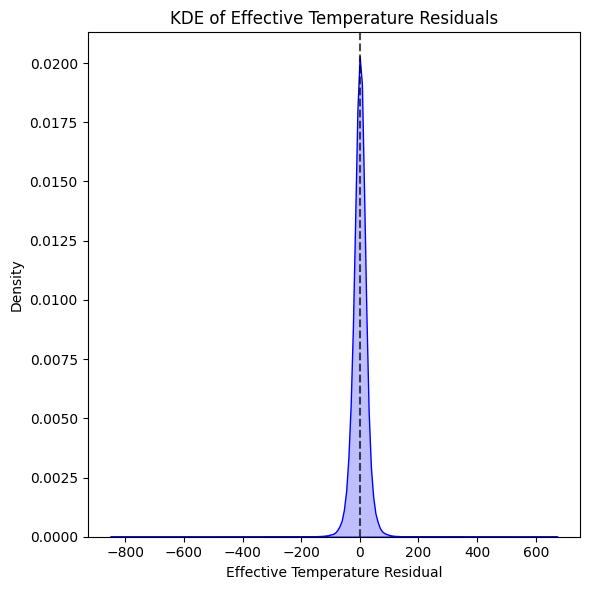

C:\Users\kiena\AppData\Local\Temp\ipykernel_13588\4075081836.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=residual, shade=True, color='blue')


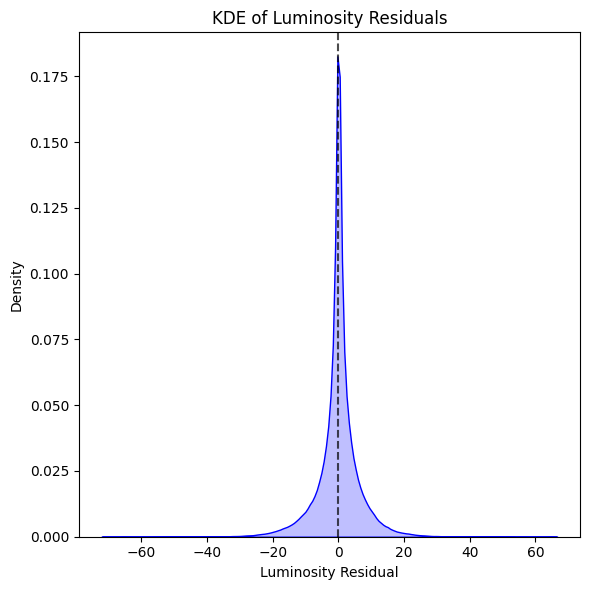

C:\Users\kiena\AppData\Local\Temp\ipykernel_13588\4075081836.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=residual, shade=True, color='blue')


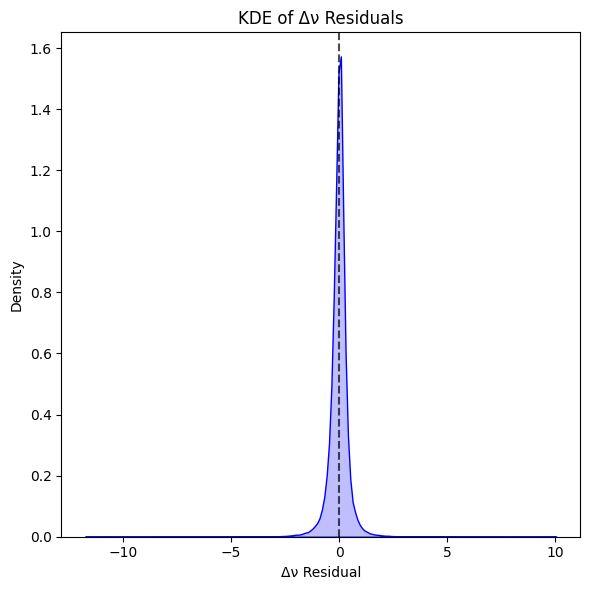

C:\Users\kiena\AppData\Local\Temp\ipykernel_13588\4075081836.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=residual, shade=True, color='blue')


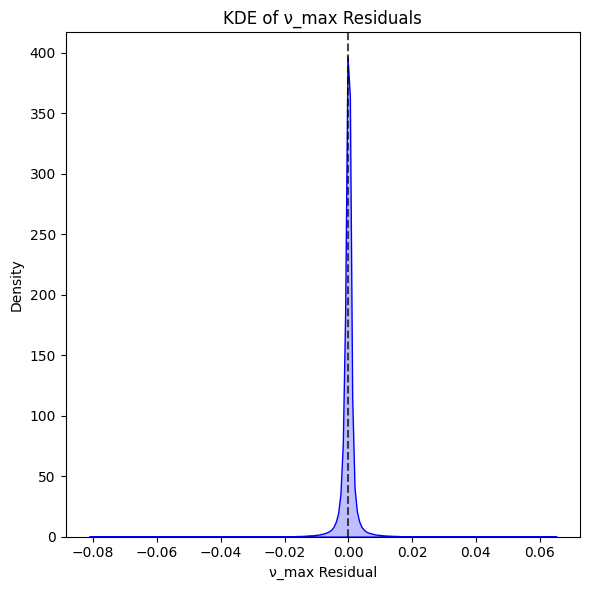

C:\Users\kiena\AppData\Local\Temp\ipykernel_13588\4075081836.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=residual, shade=True, color='blue')


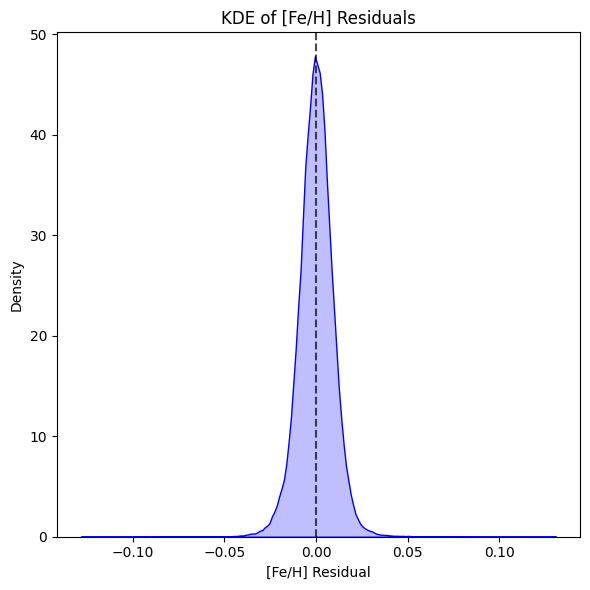

In [32]:
def individual_kde_plots():
    # Compute residuals for each parameter:
    residual_teff = 10**y_pred_original[:, 0] - 10**y_test_original[:, 0]
    residual_luminosity = 10**y_pred_original[:, 1] - 10**y_test_original[:, 1]
    residual_dnu = 10**y_pred_original[:, 2] - 10**y_test_original[:, 2]
    residual_numax = 10**y_pred_original[:, 3] - 10**y_test_original[:, 3]
    residual_feh = y_pred_original[:, 4] - y_test_original[:, 4]

    residuals = [residual_teff, residual_luminosity, residual_dnu, residual_numax, residual_feh]
    names = ["Effective Temperature", "Luminosity", "Δν", "ν_max", "[Fe/H]"]

    # Create a KDE plot for each parameter
    for residual, name in zip(residuals, names):
        plt.figure(figsize=(6, 6))
        sns.kdeplot(x=residual, shade=True, color='blue')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)  # Draw a line at zero for reference
        plt.title(f'KDE of {name} Residuals')
        plt.xlabel(f'{name} Residual')
        plt.ylabel('Density')
        plt.tight_layout()
        plt.show()

individual_kde_plots()


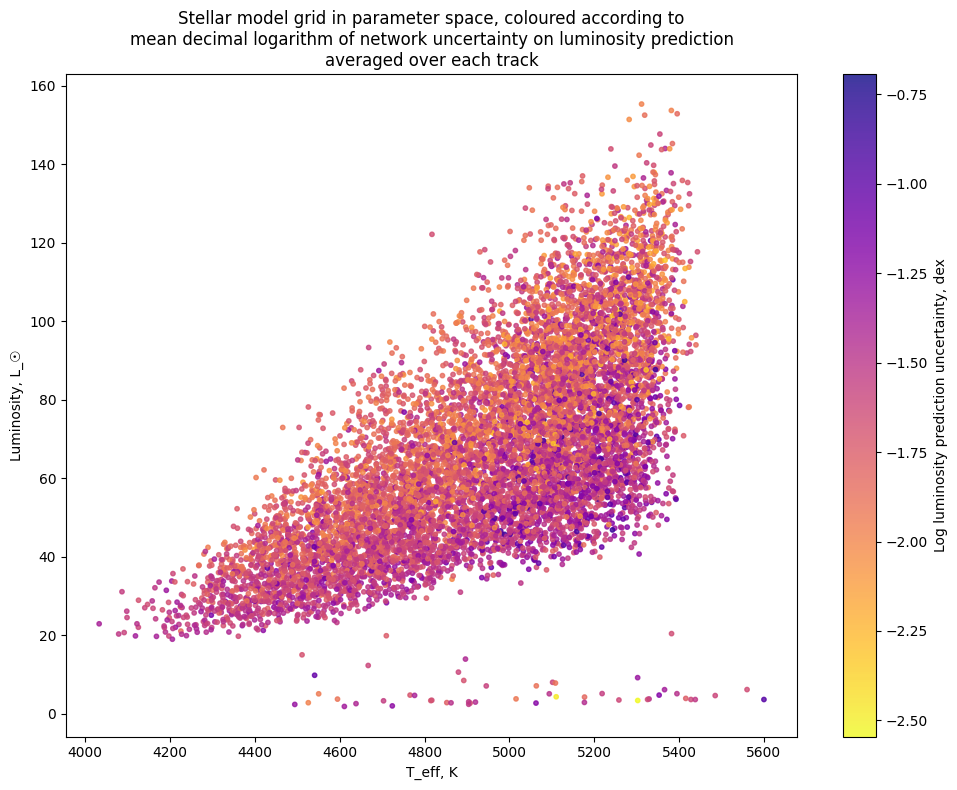

In [34]:
def plot_model_grid_with_uncertainties():
    # First, ensure that track_indices matches the test set
    # We need track indices only for the test set, not the full dataset
    _, test_indices = train_test_split(range(len(inputs)), test_size=0.2, random_state=1)
    test_track_indices = track_indices[test_indices]
    
    # Extract unique tracks in the test set
    unique_tracks = np.unique(test_track_indices)
    
    # Prepare containers for median values
    median_teff = []
    median_lum = []
    track_residuals = []
    
    # For each track, calculate the median values and mean residual
    for track_idx in unique_tracks:
        # Get indices where test_track_indices equals this track
        mask = test_track_indices == track_idx
        indices = np.where(mask)[0]
        
        if len(indices) == 0:
            continue  # Skip if no points for this track in test set
            
        # Get original values and residuals for this track
        track_teff_original = 10**y_test_original[indices, 0]  # Convert from log10 back to linear scale
        track_lum_original = 10**y_test_original[indices, 1]
        
        # Calculate residuals for this track (for luminosity)
        track_lum_residuals = log_residuals[indices, 1]  # This is residual in log space
        
        # Calculate median values for this track
        median_teff.append(np.median(track_teff_original))
        median_lum.append(np.median(track_lum_original))
        
        # Calculate mean absolute residual for this track
        mean_abs_residual = np.mean(np.abs(track_lum_residuals))
        track_residuals.append(mean_abs_residual)
    
    # Convert to arrays
    median_teff = np.array(median_teff)
    median_lum = np.array(median_lum)
    track_residuals = np.array(track_residuals)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        median_teff, 
        median_lum, 
        c=np.log10(track_residuals + 1e-10),  # Log scale for residuals (add small value to avoid log(0))
        cmap='plasma_r',  
        s=10,  # Marker size
        alpha=0.8
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log luminosity prediction uncertainty, dex')
    
    # Set axis labels and title
    plt.xlabel('T_eff, K')
    plt.ylabel('Luminosity, L_☉')
    plt.title('Stellar model grid in parameter space, coloured according to\n'
              'mean decimal logarithm of network uncertainty on luminosity prediction\n'
              'averaged over each track')
    
    # Use log scale if data spans multiple orders of magnitude
    #if np.max(median_lum)/np.min(median_lum) > 10:
    #   plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_model_grid_with_uncertainties()

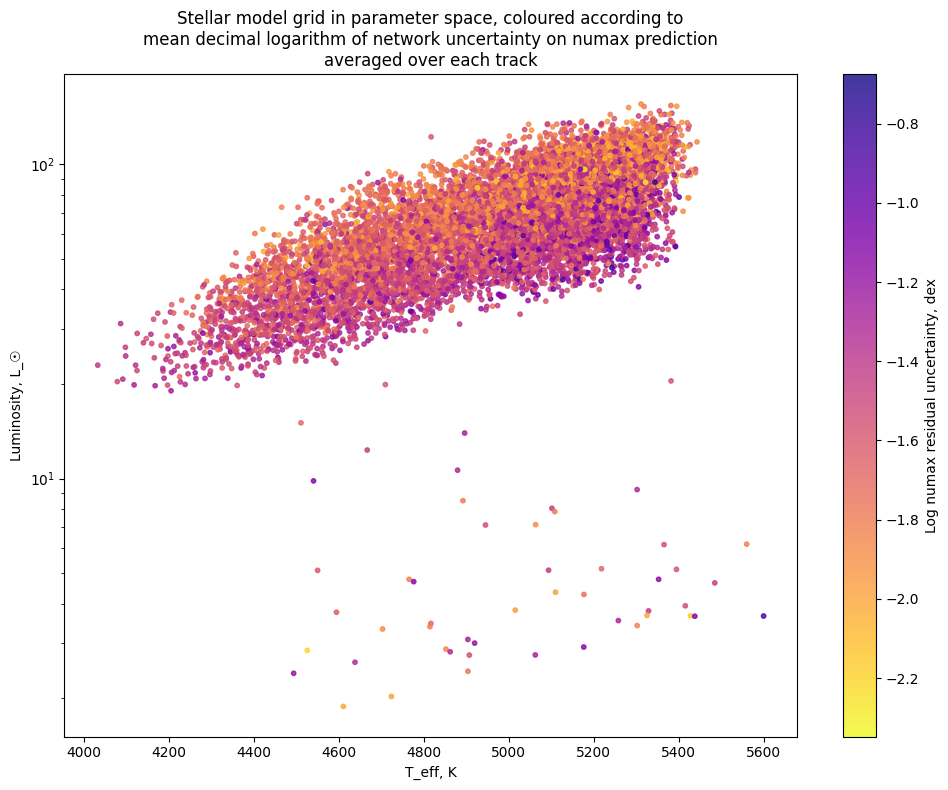

In [ ]:
def plot_model_grid_with_uncertainties_1():

# Same function as above but with colours according to numax residuals

    # First, ensure that track_indices matches the test set
    # We need track indices only for the test set, not the full dataset
    _, test_indices = train_test_split(range(len(inputs)), test_size=0.2, random_state=1)
    test_track_indices = track_indices[test_indices]
    
    # Extract unique tracks in the test set
    unique_tracks = np.unique(test_track_indices)
    
    # Prepare containers for median values and numax residuals
    median_teff = []
    median_lum = []
    track_residuals_numax = []  # Change this to store numax residuals
    
    # For each track, calculate the median values and mean residual for numax
    for track_idx in unique_tracks:
        # Get indices where test_track_indices equals this track
        mask = test_track_indices == track_idx
        indices = np.where(mask)[0]
        
        if len(indices) == 0:
            continue  # Skip if no points for this track in test set
            
        # Get original values and residuals for this track
        track_teff_original = 10**y_test_original[indices, 0]  # Convert from log10 back to linear scale
        track_lum_original = 10**y_test_original[indices, 1]
        track_numax_original = 10**y_test_original[indices, 3]  # Assuming numax is at index 3 in your original output
        
        # Calculate residuals for this track (for numax)
        track_numax_residuals = log_residuals[indices, 3]  # Residuals for numax (in log space)
        
        # Calculate median values for this track
        median_teff.append(np.median(track_teff_original))
        median_lum.append(np.median(track_lum_original))
        
        # Calculate mean absolute residual for numax (at the median point)
        mean_abs_residual_numax = np.mean(np.abs(track_numax_residuals))
        track_residuals_numax.append(mean_abs_residual_numax)
    
    # Convert to arrays
    median_teff = np.array(median_teff)
    median_lum = np.array(median_lum)
    track_residuals_numax = np.array(track_residuals_numax)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        median_teff, 
        median_lum, 
        c=np.log10(track_residuals_numax + 1e-10),  # Log scale for numax residuals (add small value to avoid log(0))
        cmap='plasma_r',
        s=10,  # Marker size
        alpha=0.8
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log numax residual uncertainty, dex')
    
    # Set axis labels and title
    plt.xlabel('T_eff, K')
    plt.ylabel('Luminosity, L_☉')
    plt.title('Stellar model grid in parameter space, coloured according to\n'
              'mean decimal logarithm of network uncertainty on numax prediction\n'
              'averaged over each track')
    
    # Use log scale if data spans multiple orders of magnitude
    if np.max(median_lum)/np.min(median_lum) > 10:
        plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_model_grid_with_uncertainties_1()
